modules imported
modules established
Baseline


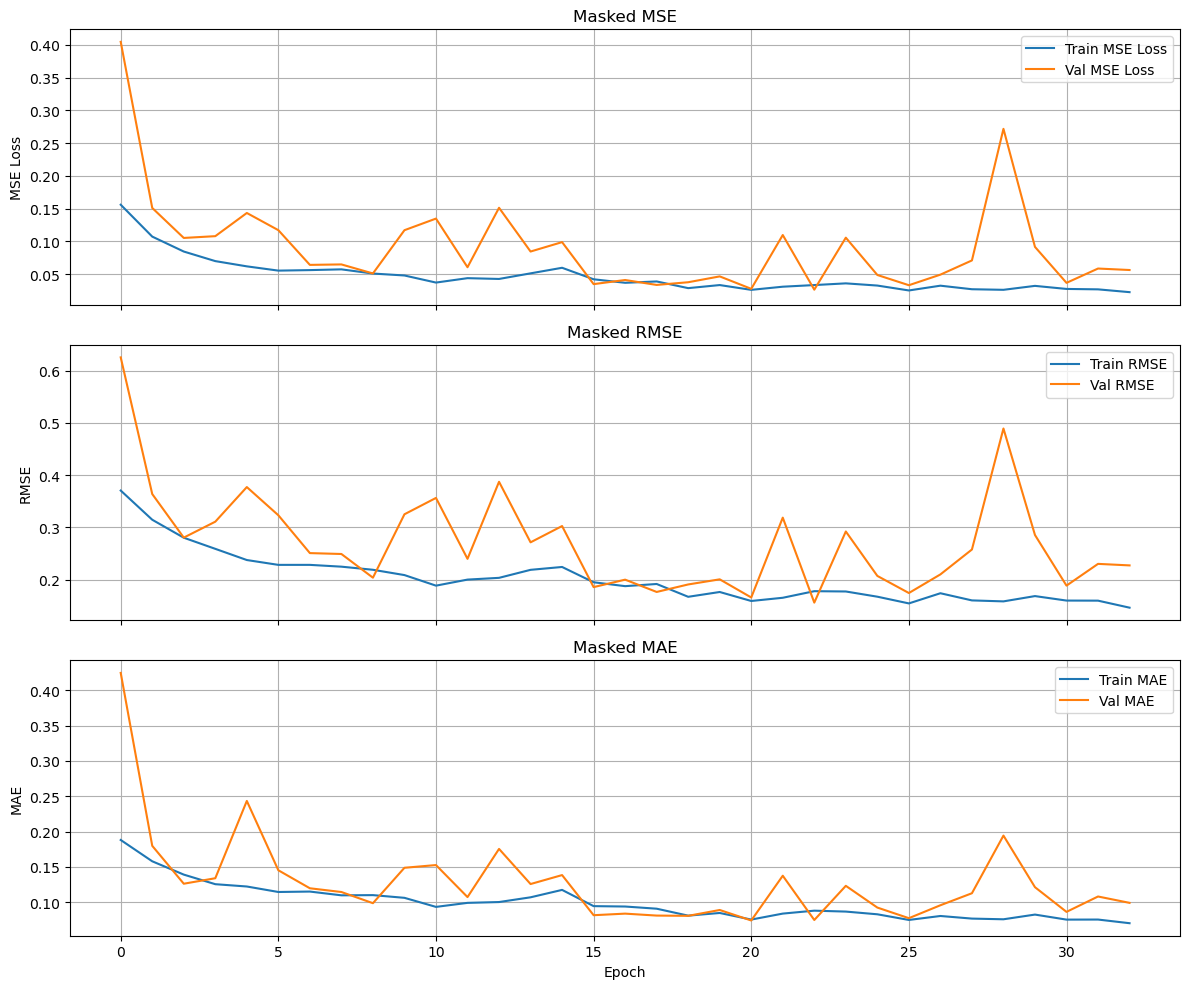

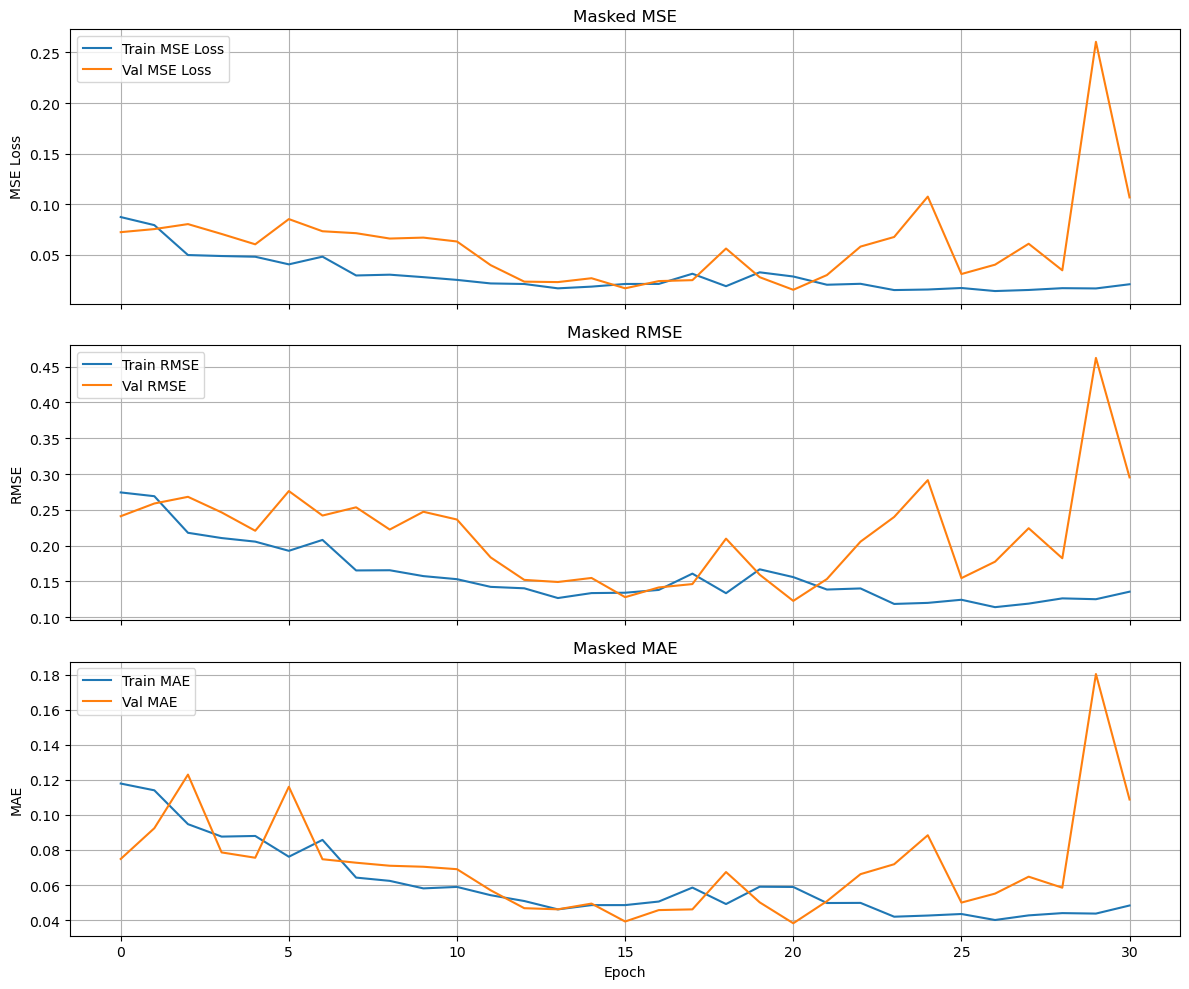

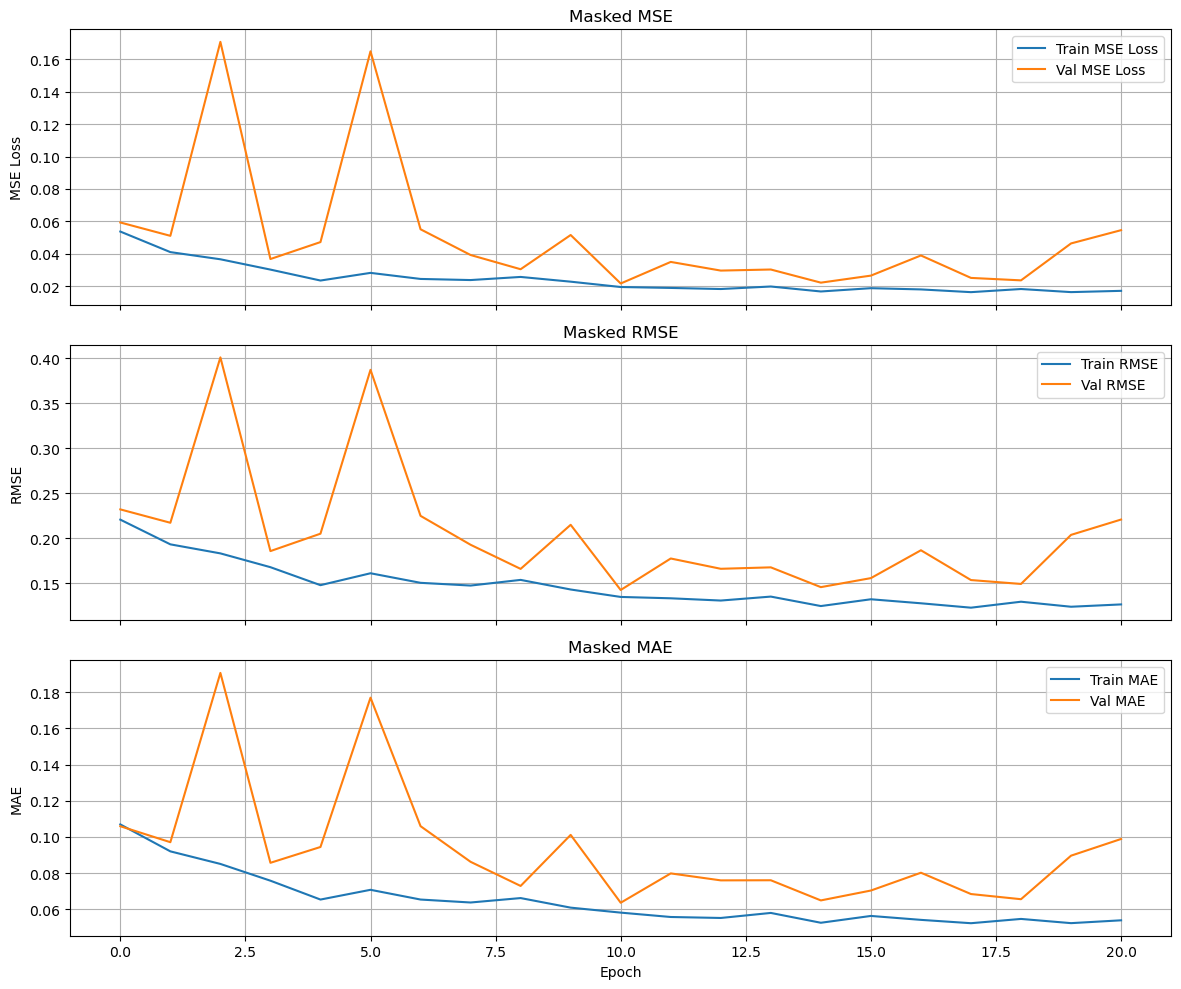

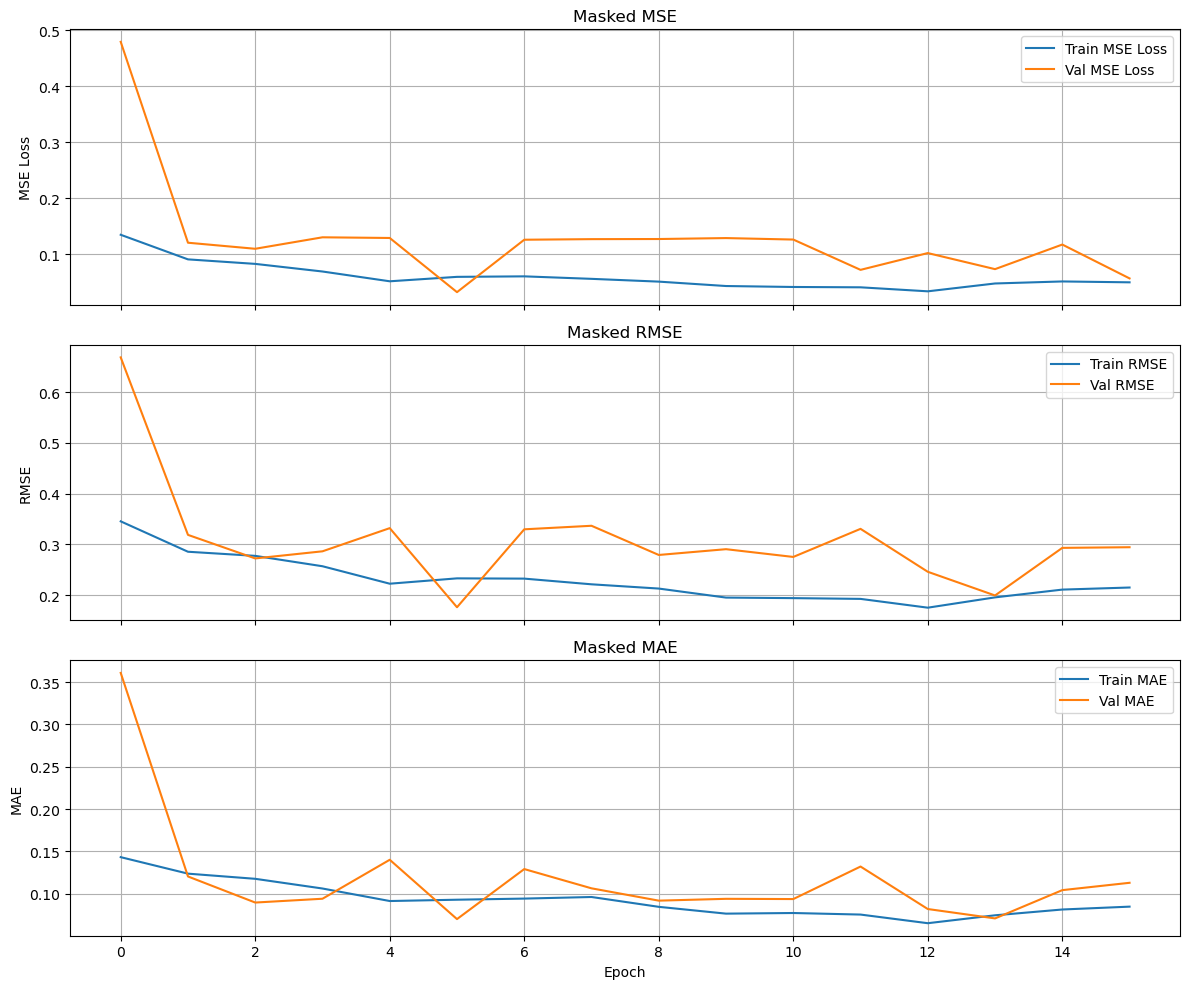

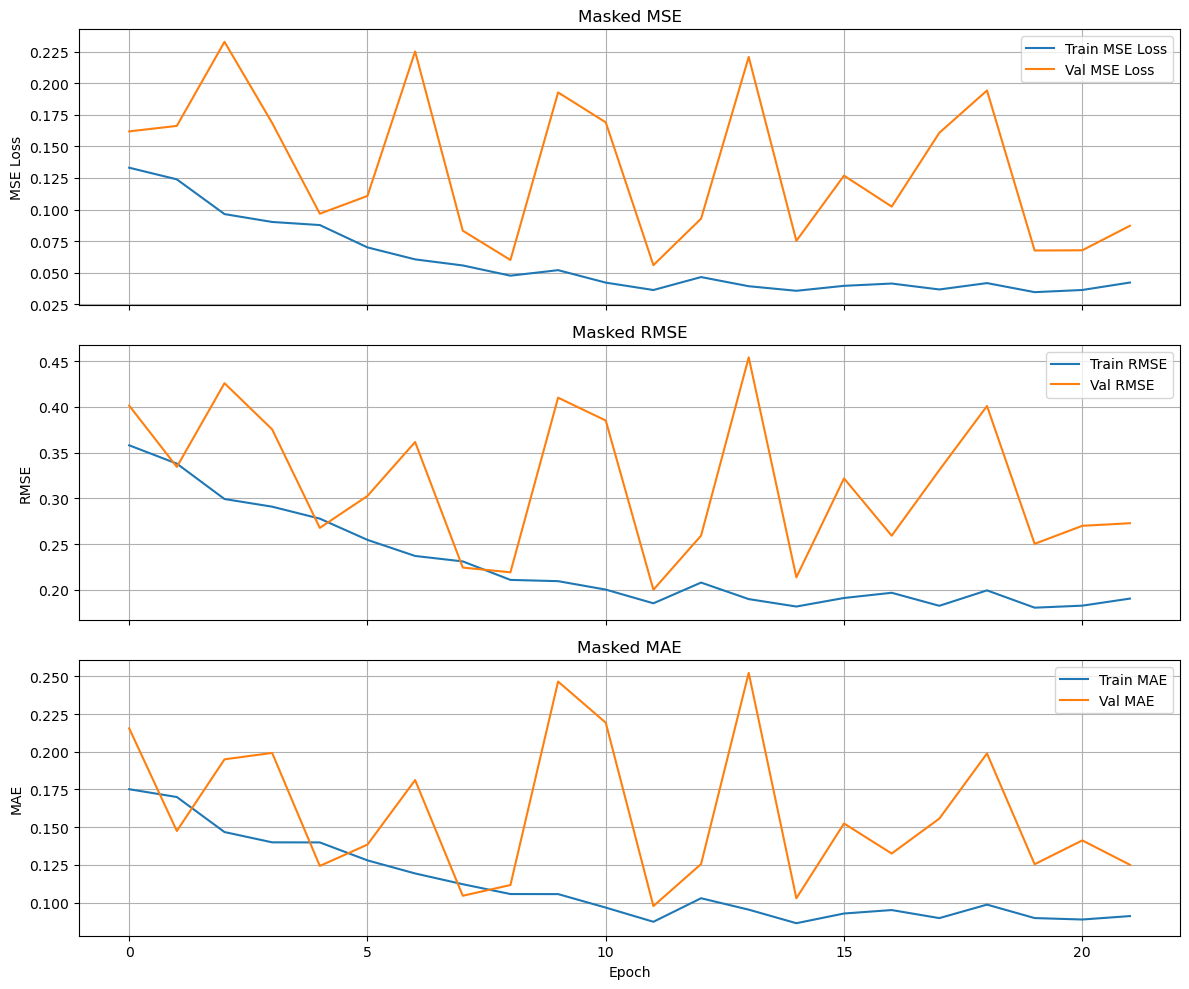

In [ ]:
# pseduo code
import sys
sys.path.append("D:/ASOML/SNOCONE")
from CNN_memoryOptimization import clear_memory, memory_efficient_prediction, DataGenerator
from CNN_preProcessing import*
from CNN_benchmarks import swe_fsca_consistency_loss_fn, make_swe_fsca_loss, masked_loss_fn, masked_mse, masked_mae, masked_rmse
from CNN_modelArchitectureBlocks import conv_block, identity_block, basic_block, resnet_model_implementation, model_predict, load_and_prepare_model, Baseline_CNN
import rasterio
import shap
import pandas as pd
from rasterio.mask import mask
from rasterio.windows import from_bounds
import psutil
from rasterio.transform import from_bounds 
import numpy as np
import sys
import os
import subprocess
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.utils import register_keras_serializable
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Input, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import Loss
import gc
import tensorflow.keras.backend as K

start_time = time.time()
print("modules established")

## establish file paths
# years = list(range(2022, 2023))
start_year = 2022
end_year = 2024
test_start_year = 2025
test_end_year =2025
Domain = "Sierras"
GPU = "N"

# workspaces
WorkspaceBase = f"D:/ASOML/{Domain}/"
phv_features = WorkspaceBase + "features/scaled/"
tree_workspace = WorkspaceBase + "treeCover/"
land_workspace = WorkspaceBase + "landCover/"
modelOuptuts = WorkspaceBase + "modelOutputs/BasinSpecifics/"
DMFSCAWorkspace = WorkspaceBase + "Rockies_DMFSCA/"
final_activation = 'relu'
architectures = ['Baseline']  # Options are: Baseline, ResNet18, ResNet34, ResNet50, CustomSWE
basin_list = ['American', 'Carson', 'Feather', 'Kaweah', 'Kern', 'Kings', 'LakesBasin', 
              'Merced', 'SanJoaquin', 'Truckee', 'Tuolumne', 'Yuba']

test_groups = [
            ('Group1', 2025, 'G1'),
            ('Group2', 2025, 'G2'), 
            ('Group3', 2025, 'G3'),
            ('Group4', 2025, 'G4'),
            ('Group5', 2025, 'G5'),
            ('Group6', 2025, 'G6')
        ]

_mae_metric = MeanAbsoluteError()
_mse_metric = MeanSquaredError()
_rmse_metric = MeanSquaredError()

# Check GPU availability
if GPU == "Y":
    print("\n Checking and start running on GPU")
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print("GPU devices:", tf.config.list_physical_devices('GPU'))
    
    # Configure GPU memory growth (prevents TensorFlow from allocating all GPU memory)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU memory growth enabled")
        except RuntimeError as e:
            print(e)
    
    # Verify TensorFlow is using GPU
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)
        print("GPU computation result:", c)

from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

for basin_name in basin_list:
    for architecture in architectures:
        print(architecture)
        # shapeChecks = "N"
        ## seting folder
        
        # create folder for model outputs
        os.makedirs(modelOuptuts + f"{basin_name}_{str(timestamp)}/", exist_ok=True)
        inter_model_outWorkspace = modelOuptuts + f"{basin_name}_{str(timestamp)}/"
        
        f = open(inter_model_outWorkspace + f"code_output_{basin_name}_{timestamp}.txt", "a")
        sys.stdout = f
        print("MODEL OUTPUTS TO BE PRINTED TO THIS DOC")
        print(f"\n {basin_name} is being processed and tested")
        X, y, featureNames = target_feature_stacks_basins(start_year=start_year, 
                                                   end_year=end_year, 
                                                   WorkspaceBase=WorkspaceBase, 
                                                   ext = "nonull_fnl.tif", 
                                                   vegetation_path = tree_workspace, 
                                                   landCover_path = land_workspace, 
                                                   phv_path = phv_features , 
                                                   target_shape=(256,256),
                                                   basin_name=basin_name,
                                                   shapeChecks="Y")
        
        print("")
        print("Shape of input data")
        print(f"feature shape: {X.shape}")
        print(f"target shape: {y.shape}")
        feat_shape = X.shape
        featNo = feat_shape[-1]
        if X.shape[0] == 0:
            print("no basins for training")
            continue
        else: 
            print(featNo)
            print(featureNames)
            
            # split between training and test data
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True)
            print("***")
            print("________________________________ Training and Validation Data Shapes ________________________________")
            print("Training data shape:", X_train.shape, y_train.shape)
            print("Validation data shape:", X_valid.shape, y_valid.shape)
            print("***")
            
            x_trainShape = X_train.shape
            x_validShape = X_valid.shape
            
            # Assuming featNo and final_activation are defined in your original code
            featNo = featNo  # Replace with your actual feature count
            final_activation = final_activation  # Replace with your actual activation
            
            # Create the model
            model = resnet_model_implementation(featNo, architecture, final_activation)
            
            # Your existing custom loss function
            from tensorflow.keras.losses import MeanSquaredError
            from tensorflow.keras.metrics import MeanAbsoluteError
            
            custom_loss_fn = make_swe_fsca_loss(
                base_loss_fn=MeanSquaredError(),
                penalty_weight=0.3,
                swe_threshold=0.01,
                fsca_threshold=0.01,
                mask_value=-1
            )
            
            # Compile with your existing setup
            model.compile(
                optimizer='adam',
                loss=custom_loss_fn,
                metrics=[masked_rmse, masked_mae, masked_mse]
            )
            
            print(model.summary())
            
            # establish the model
            checkpoint = ModelCheckpoint(
                f"{inter_model_outWorkspace}/best_weights_{basin_name}_{timestamp}.weights.h5", 
                monitor="val_loss",
                verbose=1, 
                save_best_only=True, 
                mode='min'
            )
            early_stopping = EarlyStopping(monitor="val_masked_rmse", mode='min', verbose=1, patience=10, restore_best_weights=True)
            
            
            batch_size = 8
            train_generator = DataGenerator(X_train, y_train, batch_size=batch_size)
            valid_generator = DataGenerator(X_valid, y_valid, batch_size=batch_size)
            
            history = model.fit(
                train_generator,
                validation_data=valid_generator,
                epochs=100,
                callbacks=[checkpoint, early_stopping]
            )
        
            ## plotting results 
            fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
            # 1. Masked MSE (used as loss)
            axs[0].plot(history.history['loss'], label='Train MSE Loss')
            axs[0].plot(history.history['val_loss'], label='Val MSE Loss')
            axs[0].set_ylabel('MSE Loss')
            axs[0].set_title('Masked MSE')
            axs[0].legend()
            axs[0].grid(True)
            # 2. Masked RMSE
            axs[1].plot(history.history['masked_rmse'], label='Train RMSE')
            axs[1].plot(history.history['val_masked_rmse'], label='Val RMSE')
            axs[1].set_ylabel('RMSE')
            axs[1].set_title('Masked RMSE')
            axs[1].legend()
            axs[1].grid(True)
            # 3. Masked MAE
            axs[2].plot(history.history['masked_mae'], label='Train MAE')
            axs[2].plot(history.history['val_masked_mae'], label='Val MAE')
            axs[2].set_ylabel('MAE')
            axs[2].set_title('Masked MAE')
            axs[2].set_xlabel('Epoch')
            axs[2].legend()
            axs[2].grid(True)
            
            plt.tight_layout()
            plt.savefig(inter_model_outWorkspace + f"{basin_name}_Model_error_epochs.png")
            plt.show()
            
            ## Add metrics to recurring error tracking sheet
            metrics_to_track = ['val_masked_rmse', 'val_masked_mse', 'val_masked_mae']
            best_metrics = {}
            print("\nValidation Metric Progression:")
            for metric in metrics_to_track:
                values = history.history.get(metric, [])
                if values:
                    best_val = min(values)
                    best_metrics[metric] = best_val
                    print(f"{metric}: Start = {values[0]:.4f}, End = {values[-1]:.4f}")
                    print(f"{metric}: Best = {best_val:.4f}")
                else:
                    print(f"{metric}: Not found in history.")
            print(f"Final activation function: {final_activation}")
            
            # Example variables
            feature_csv = modelOuptuts + f"{Domain}_{basin_name}_model_featureList_summary.csv" 
            column_name = timestamp  
            feature_list = featureNames    
            new_column_df = pd.DataFrame({column_name: feature_list})
            
            # If the file already exists, load it and append the new column
            if os.path.exists(feature_csv):
                existing_df = pd.read_csv(feature_csv)
                # Reindex the existing dataframe 
                max_len = max(len(existing_df), len(new_column_df))
                existing_df = existing_df.reindex(range(max_len))
                new_column_df = new_column_df.reindex(range(max_len))
                # Combine horizontally
                combined_df = pd.concat([existing_df, new_column_df], axis=1)
            else:
                combined_df = new_column_df
            
            # Save back to CSV
            combined_df.to_csv(feature_csv, index=False)
            
            # add metrics to csv
            modelStatsCSV = modelOuptuts + f"{Domain}_{basin_name}_modelSummary_stats.csv"
            
            error_stats = {
                'ModelRun':[timestamp],
                'FeatureNum': [featNo],
                'Architecture': [architecture],
                'FinalActivation': [final_activation],
                'X_TrainShape': [x_trainShape[0]],
                'X_ValidShape': [x_validShape[0]],
                'RMSE': [best_metrics['val_masked_rmse']],
                'MSE': [best_metrics['val_masked_mse']], 
                'MAE': [best_metrics['val_masked_mae']]
                
            }
            
            df = pd.DataFrame(error_stats)
            
            # Append or write new file
            if os.path.exists(modelStatsCSV):
                df.to_csv(modelStatsCSV, mode='a', header=False, index=False)
            else:
                df.to_csv(modelStatsCSV, index=False)
            
            del X_train, X_valid, y_train, y_valid, X, y
            K.clear_session()
            gc.collect()
        
            del history 
            clear_memory()
    
            ## apply to test groups
            X_test, y_test, featureNames = target_feature_stacks_basins(start_year=test_start_year, 
                                                       end_year=test_end_year, 
                                                       WorkspaceBase=f"D:/ASOML/{Domain}/test_2025_basin/", 
                                                       ext = "nonull_fnl.tif", 
                                                       vegetation_path = tree_workspace, 
                                                       landCover_path = land_workspace, 
                                                       phv_path = phv_features , 
                                                       target_shape=(256,256),
                                                       basin_name=basin_name,
                                                       shapeChecks="Y")
    
            ## Apply model to test data
            print(f"\n=== Applying trained model to test data ===")
            
            # Load test data (X and y are already loaded from your code)
            print(f"Test data shape: {X_test.shape}, {y_test.shape}")
            if X_test.size == 0:
                continue
            else: 
                # Create a new model with the same architecture
                test_model = resnet_model_implementation(featNo, architecture, final_activation)
                
                # Load the best weights from training
                best_weights_path = f"{inter_model_outWorkspace}/best_weights_{basin_name}_{timestamp}.weights.h5"
                test_model.load_weights(best_weights_path)
                
                # Compile the model (needed for evaluation metrics)
                test_model.compile(
                    optimizer='adam',
                    loss=custom_loss_fn,
                    metrics=[masked_rmse, masked_mae, masked_mse]
                )
                
                # Make predictions
                print("Making predictions on test data...")
                predictions = test_model.predict(X_test, batch_size=32, verbose=1)
                
                # Evaluate the model on test data
                print("Evaluating model on test data...")
                test_metrics = test_model.evaluate(X_test, y_test, batch_size=32, verbose=1)
                
                # Print test metrics
                metric_names = ['loss', 'masked_rmse', 'masked_mae', 'masked_mse']
                print(f"\nTest Results for {basin_name}:")
                for i, metric_name in enumerate(metric_names):
                    if i < len(test_metrics):
                        print(f"{metric_name}: {test_metrics[i]:.4f}")
                
                # Save predictions
                predictions_path = f"{inter_model_outWorkspace}/{basin_name}_test_predictions.npy"
                np.save(predictions_path, predictions)
                print(f"Predictions saved to: {predictions_path}")
                
                # Save actual test targets for comparison
                actuals_path = f"{inter_model_outWorkspace}/{basin_name}_test_actuals.npy"
                np.save(actuals_path, y_test)
                print(f"Test actuals saved to: {actuals_path}")
                
                # Save test metrics to CSV
                test_metrics_csv = modelOuptuts + f"{Domain}_{basin_name}_testResults.csv"
                
                test_results = {
                    'ModelRun': [timestamp],
                    'Basin': [basin_name],
                    'Architecture': [architecture],
                    'TestSamples': [X_test.shape[0]],
                    'Test_Loss': [test_metrics[0] if len(test_metrics) > 0 else None],
                    'Test_RMSE': [test_metrics[1] if len(test_metrics) > 1 else None],
                    'Test_MAE': [test_metrics[2] if len(test_metrics) > 2 else None],
                    'Test_MSE': [test_metrics[3] if len(test_metrics) > 3 else None]
                }
                
                test_df = pd.DataFrame(test_results)
                
                # Append to existing CSV or create new one
                if os.path.exists(test_metrics_csv):
                    test_df.to_csv(test_metrics_csv, mode='a', header=False, index=False)
                else:
                    test_df.to_csv(test_metrics_csv, index=False)
                
                # Create visualizations comparing predictions vs actual
                print(f"Test evaluation completed for {basin_name}")
                print(f"Results saved to: {inter_model_outWorkspace}")
                
                # Clean up memory
                del test_model, predictions
                K.clear_session()
                gc.collect()
                
                print("\n=== Test data evaluation completed ===")